In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns

In [ ]:
def read_file(ticker):
    daily_chart_path = os.path.join("..", "data", "chart", "daily")
    file_path = os.path.join(daily_chart_path, f"{ticker}.parquet")
    
    # 데이터 읽기
    df = pd.read_parquet(file_path, engine="pyarrow")
    # 날짜 인덱스
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    return df 
    

In [ ]:
def normal_test(df):
    
    # 로그 수익률
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    log_rtns = df['log_returns'].dropna()
    
    # 왜도
    skew = log_rtns.skew()
    # 첨도
    kurt = log_rtns.kurtosis()
    
    print(f"왜도(Skewness): {skew:.4f}")
    print(f"첨도(kurtosis): {kurt:.4f}")
    
    # MDD
    window = 252
    rolling_max = df['close'].rolling(window, min_periods=1).max()
    daily_drawdown = df['close'] / rolling_max -1.0
    max_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

    print(f"최근 1년 내 최대 낙폭(MDD): {max_drawdown.min():.2%}")
    
    worst_5 = df.sort_values(by='log_returns').head(5)
    best_5 = df.sort_values(by='log_returns').tail(5)

    print(worst_5[['log_returns', 'close']])
    print(best_5[['log_returns', 'close']])
    
    return log_rtns, skew, kurt, max_drawdown



In [3]:
def draw_plot(log_rtns, ticker, save=True):
    # 그래프 저장 위치
    daily_plot_path = os.path.join("..", "data", "plot", 'normal_test')
    # 폴더가 없으면 생성
    if not os.path.exists(daily_plot_path):
        os.makedirs(daily_plot_path)
        #print(f"폴더 '{daily_plot_path}'을 생성했습니다.")
    #else:
        #print(f"폴더 '{daily_plot_path}'이 이미 존재합니다.")
    
    
    # 인덱스에서 시작일과 종료일 추출 (YYYY-MM-DD 형식)
    start_date = log_rtns.index.min().strftime('%Y-%m-%d')
    end_date = log_rtns.index.max().strftime('%Y-%m-%d')
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6)) 
    
    # 히스토그램
    sns.histplot(log_rtns, kde=True, color="royalblue", stat='density', bins=100)
    mu, std = log_rtns.mean(), log_rtns.std()
    x= np.linspace(log_rtns.min(), log_rtns.max(), 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution')

    plt.suptitle(f'{ticker} Log Returns Distribution', fontsize=16)
    plt.title(f'Period: {start_date} ~ {end_date} \n (Skew: {log_rtns.skew():.2f}, Kurt: {log_rtns.kurt():.2f})', fontsize=10)
    plt.legend()
    if save:
        file_path = os.path.join(daily_plot_path, f'{ticker}_{start_date}_{end_date}_log_return_hist.png')
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Q-Q plot
    plt.figure(figsize=(8, 6))
    stats.probplot(log_rtns, dist="norm", plot=plt)
    plt.suptitle(f'{ticker} Q-Q Plot', fontsize=16)
    plt.title(f'Period: {start_date} ~ {end_date} \n (Skew: {log_rtns.skew():.2f}, Kurt: {log_rtns.kurt():.2f})', fontsize=10)
    if save:
        file_path = os.path.join(daily_plot_path, f'{ticker}_{start_date}_{end_date}_QQ.png')
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.show()

왜도(Skewness): 0.1922
첨도(kurtosis): 2.2736
최근 1년 내 최대 낙폭(MDD): -43.17%
            log_returns     close
date                             
2024-08-05    -0.108716   71400.0
2026-02-02    -0.064996  150400.0
2026-02-05    -0.059701  159300.0
2025-11-21    -0.059383   94800.0
2025-11-04    -0.057423  104900.0
            log_returns     close
date                             
2026-01-02     0.069271  128500.0
2024-11-15     0.069661   53500.0
2026-01-05     0.072049  138100.0
2026-02-03     0.107685  167500.0
2024-02-19          NaN   73800.0


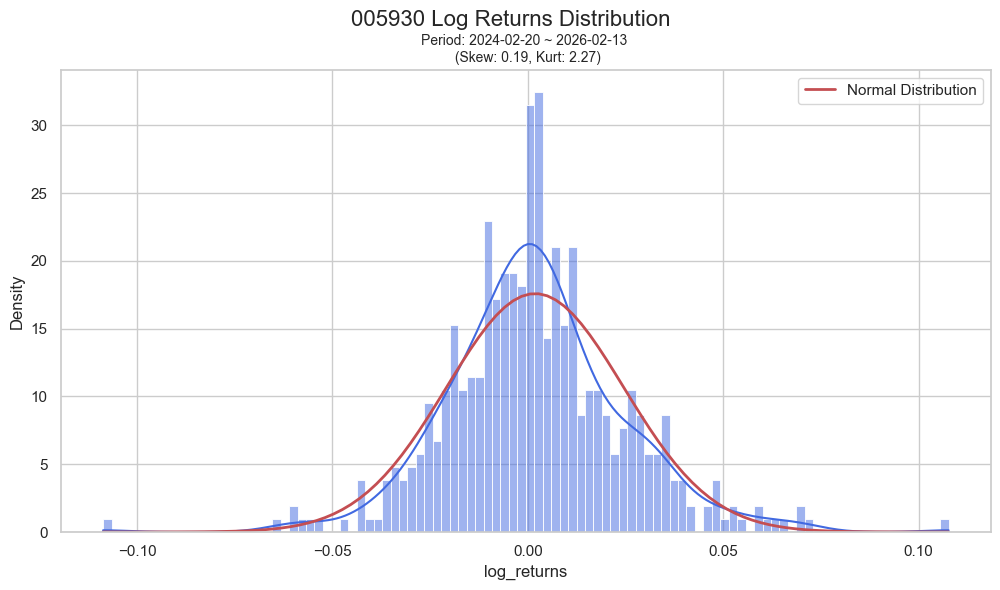

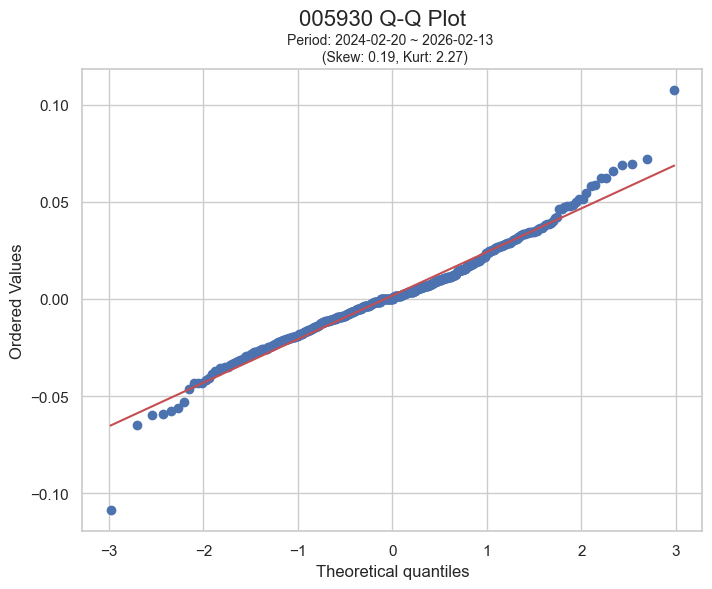

In [4]:
ticker = "005930"
log_rtns, skew, kurt, mdd = normal_test(ticker)
draw_plot(log_rtns=log_rtns, ticker=ticker)

In [5]:
log_rtns

date
2024-02-20   -0.006798
2024-02-21   -0.004101
2024-02-22    0.001369
2024-02-23   -0.002740
2024-02-26   -0.001373
                ...   
2026-02-09    0.048009
2026-02-10   -0.003612
2026-02-11    0.011991
2026-02-12    0.062376
2026-02-13    0.014453
Name: log_returns, Length: 484, dtype: float64

In [6]:
print(os.path)

<module 'ntpath' (frozen)>
